In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tina32052021","key":"5ee160a621eea385361e4b4f8533e23b"}'}

In [ ]:
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jenny18/honey-bee-annotated-images
!mkdir -p base_dir/input
!unzip -d base_dir/input honey-bee-annotated-images.zip

!mkdir -p base_dir/train_dir/1_healthy
!mkdir -p base_dir/train_dir/2_fvar
!mkdir -p base_dir/train_dir/3_var
!mkdir -p base_dir/train_dir/4_ant
!mkdir -p base_dir/train_dir/5_robbed
!mkdir -p base_dir/train_dir/6_queen

!mkdir -p base_dir/val_dir/1_healthy
!mkdir -p base_dir/val_dir/2_fvar
!mkdir -p base_dir/val_dir/3_var
!mkdir -p base_dir/val_dir/4_ant
!mkdir -p base_dir/val_dir/5_robbed
!mkdir -p base_dir/val_dir/6_queen

串流輸出內容已截斷至最後 5000 行。
  inflating: base_dir/input/bee_imgs/bee_imgs/003_250.png  
  inflating: base_dir/input/bee_imgs/bee_imgs/003_251.png  
  inflating: base_dir/input/bee_imgs/bee_imgs/003_252.png  
  inflating: base_dir/input/bee_imgs/bee_imgs/003_253.png  
  inflating: base_dir/input/bee_imgs/bee_imgs/003_254.png  
  inflating: base_dir/input/bee_imgs/bee_imgs/003_255.png  
  inflating: base_dir/input/bee_imgs/bee_imgs/003_256.png  
  inflating: base_dir/input/bee_imgs/bee_imgs/003_257.png  
  inflating: base_dir/input/bee_imgs/bee_imgs/003_258.png  
  inflating: base_dir/input/bee_imgs/bee_imgs/003_259.png  
  inflating: base_dir/input/bee_imgs/bee_imgs/003_260.png  
  inflating: base_dir/input/bee_imgs/bee_imgs/003_261.png  
  inflating: base_dir/input/bee_imgs/bee_imgs/003_262.png  
  inflating: base_dir/input/bee_imgs/bee_imgs/003_263.png  
  inflating: base_dir/input/bee_imgs/bee_imgs/003_264.png  
  inflating: base_dir/input/bee_imgs/bee_imgs/003_265.png  
  inflating: base_d

In [ ]:
from numpy.random import seed
seed(101)
import tensorflow
tensorflow.random.set_seed(101)

import pandas as pd
import numpy as np
#import keras


from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import categorical_accuracy

import os
import cv2

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# To reduce the class imbalance in the train and validation set, the number of
# rows in class 'healthy' will be reduced to this number:

HEALTHY_SAMPLE_SIZE = 579

# The approx. total number of images we want in each class after doing image augmentation.
# We won't be doing image augmentation on the fly.
NUM_IMAGES_WANTED = 3000 # incl. class 'healthy'

# MobileNet needs input images with shape 224x224x3
IMAGE_SIZE = 224
IMAGE_CHANNELS = 3

IMAGE_PATH = "base_dir/input/bee_imgs/bee_imgs/"

In [ ]:
# What files are available?

os.listdir("base_dir/input")

['bee_data.csv', 'bee_imgs']

In [ ]:
df = pd.read_csv('base_dir/input/bee_data.csv')
df['health'].value_counts()

healthy                       3384
few varrao, hive beetles       579
Varroa, Small Hive Beetles     472
ant problems                   457
hive being robbed              251
missing queen                   29
Name: health, dtype: int64

In [ ]:
df_data = pd.read_csv('base_dir/input/bee_data.csv')

df_data.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


In [ ]:
# take a random sample of class 'healthy'
df = df_data[df_data['health'] == 'healthy'].sample(HEALTHY_SAMPLE_SIZE, random_state=101)

# remove class 'healthy' from the dataframe
df_data = df_data[df_data['health'] != 'healthy']

# concat df and df_data
df_data = pd.concat([df_data, df], axis=0).reset_index(drop=True)

# shuffle the new dataframe
df_data = shuffle(df_data)

# check the new class distribution
df_data['health'].value_counts()

few varrao, hive beetles      579
healthy                       579
Varroa, Small Hive Beetles    472
ant problems                  457
hive being robbed             251
missing queen                  29
Name: health, dtype: int64

In [ ]:
y = df_data['health']

df_train, df_val = train_test_split(df_data, test_size=0.1, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(2130, 9)
(237, 9)


In [ ]:
df_train['health'].value_counts()

healthy                       521
few varrao, hive beetles      521
Varroa, Small Hive Beetles    425
ant problems                  411
hive being robbed             226
missing queen                  26
Name: health, dtype: int64

In [ ]:
df_val['health'].value_counts()

healthy                       58
few varrao, hive beetles      58
Varroa, Small Hive Beetles    47
ant problems                  46
hive being robbed             25
missing queen                  3
Name: health, dtype: int64

In [ ]:
# Set the 'file' column as the index in df_data
df_data.set_index('file', inplace=True)

In [ ]:
# Get a list of train and val images
train_list = list(df_train['file'])
val_list = list(df_val['file'])

# Key:
# healthy = healthy
# fvar = few varrao, hive beetles
# var = Varroa, Small Hive Beetles
# ant = ant problems
# robbed = hive being robbed
# queen = missing queen



# Transfer the train images.
# Note that we re-name the files during the transfer using a number sequence. This is just a
# safety measure help the generators create a repeatable sequence of images.
# Otherwise I think they could mix them up and give us confusing results.

length = len(train_list)

for i in range(0,length):

    fname = train_list[i]
    image = fname
    description = df_data.loc[image,'health']

    # map the class descriptions to folder names
    if description == 'healthy':
        label = '1_healthy'
    if description == 'few varrao, hive beetles':
        label = '2_fvar'
    if description == 'Varroa, Small Hive Beetles':
        label = '3_var'
    if description == 'ant problems':
        label = '4_ant'
    if description == 'hive being robbed':
        label = '5_robbed'
    if description == 'missing queen':
      label = '6_queen'


    # source path to image
    src = os.path.join('base_dir/input/bee_imgs/bee_imgs', fname)
    # chage the file name
    new_name = str(i) + '_' + 'train'+ '.png'
    # destination path to image
    dst = os.path.join('base_dir/train_dir', label, new_name)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images

length = len(val_list)

for i in range(0,length):

    fname = val_list[i]
    image = fname
    description = df_data.loc[image,'health']

     # map the class descriptions to folder names
    if description == 'healthy':
        label = '1_healthy'
    if description == 'few varrao, hive beetles':
        label = '2_fvar'
    if description == 'Varroa, Small Hive Beetles':
        label = '3_var'
    if description == 'ant problems':
        label = '4_ant'
    if description == 'hive being robbed':
        label = '5_robbed'
    if description == 'missing queen':
        label = '6_queen'

    # source path to image
    src = os.path.join('base_dir/input/bee_imgs/bee_imgs', fname)
    # chage the file name
    new_name = str(i) + '_' + 'val' + '.png'
    # destination path to image
    dst = os.path.join('base_dir/val_dir', label, new_name)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [ ]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/1_healthy')))
print(len(os.listdir('base_dir/train_dir/2_fvar')))
print(len(os.listdir('base_dir/train_dir/3_var')))
print(len(os.listdir('base_dir/train_dir/4_ant')))
print(len(os.listdir('base_dir/train_dir/5_robbed')))
print(len(os.listdir('base_dir/train_dir/6_queen')))

521
521
425
411
226
26


In [ ]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/1_healthy')))
print(len(os.listdir('base_dir/val_dir/2_fvar')))
print(len(os.listdir('base_dir/val_dir/3_var')))
print(len(os.listdir('base_dir/val_dir/4_ant')))
print(len(os.listdir('base_dir/val_dir/5_robbed')))
print(len(os.listdir('base_dir/val_dir/6_queen')))

58
58
47
46
25
3


In [ ]:
# note that we are not augmenting class 'healthy'
class_list = ['1_healthy', '2_fvar','3_var','4_ant','5_robbed','6_queen']

for item in class_list:

    # We are creating temporary directories here because we delete these directories later.

    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'healthy'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and NOT to the images themselves
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator to generate augmented images for each class.
    datagen = ImageDataGenerator(
        #rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.01,
        #horizontal_flip=True,
        #vertical_flip=True,
        brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 9

    aug_datagen = datagen.flow_from_directory(path,
                                        save_to_dir=save_path, # this is where the images are saved
                                        save_format='jpg',
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=batch_size)



    # Generate the augmented images and add them to the training folders

    # NUM_IMAGES_WANTED = total number of images we want to have in each class
    # We will use image augmentation to create the additional images.

    num_files = len(os.listdir(img_dir))

    # Just a calculation to get approx. the same amount of images for each class.
    num_batches = int(np.ceil((NUM_IMAGES_WANTED-num_files)/batch_size))

    # Run the generator and create augmented images.
    # Note that these images are automatically stored in a folder. The path
    # to the save folder is specified as a parameter in the generator above.
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)

    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 521 images belonging to 1 classes.
Found 521 images belonging to 1 classes.
Found 425 images belonging to 1 classes.
Found 411 images belonging to 1 classes.
Found 226 images belonging to 1 classes.
Found 26 images belonging to 1 classes.


In [ ]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('base_dir/train_dir/1_healthy')))
print(len(os.listdir('base_dir/train_dir/2_fvar')))
print(len(os.listdir('base_dir/train_dir/3_var')))
print(len(os.listdir('base_dir/train_dir/4_ant')))
print(len(os.listdir('base_dir/train_dir/5_robbed')))
print(len(os.listdir('base_dir/train_dir/6_queen')))

3001
3001
2973
2985
2919
2895


In [ ]:
# Check how many val images we have in each folder.

print(len(os.listdir('base_dir/val_dir/1_healthy')))
print(len(os.listdir('base_dir/val_dir/2_fvar')))
print(len(os.listdir('base_dir/val_dir/3_var')))
print(len(os.listdir('base_dir/val_dir/4_ant')))
print(len(os.listdir('base_dir/val_dir/5_robbed')))
print(len(os.listdir('base_dir/val_dir/6_queen')))

58
58
47
46
25
3


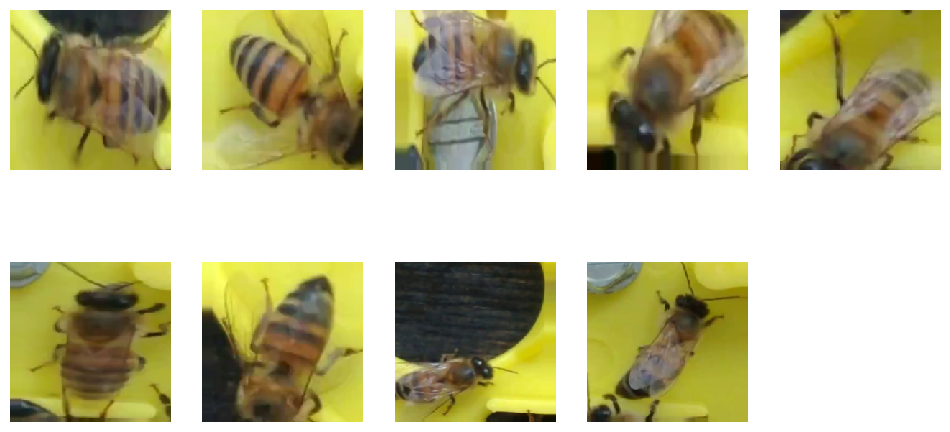

In [ ]:
# plots images with labels within jupyter notebook
# source: https://github.com/smileservices/keras_utils/blob/master/utils.py

def plots(ims, figsize=(12,6), rows=2, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

plots(imgs, titles=None) # titles=labels will display the image labels

In [ ]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [ ]:
datagen = ImageDataGenerator(preprocessing_function=
                             tensorflow.keras.applications.mobilenet.preprocess_input)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(image_size,image_size),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(image_size,image_size),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled.
# Here we will be using the val set as the test dataset because we need to run predict
# in order to generate the confusion matrix.
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(image_size,image_size),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 17774 images belonging to 6 classes.
Found 237 images belonging to 6 classes.
Found 237 images belonging to 6 classes.


In [ ]:
# Create a copy of a mobilenet model.
# Please ensure your kaggle kernel is set to 'Internet Connected'.

mobile = tensorflow.keras.applications.mobilenet.MobileNet()

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [ ]:
type(mobile.layers)

list

In [ ]:
# How many layers does MobileNet have?
len(mobile.layers)

91

In [ ]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-5].output

# Create a new dense layer for predictions
# 6 corresponds to the number of classes
#x = Dropout(0.25)(x)

x = Flatten()(x)
predictions = Dense(6, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [ ]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

In [ ]:
model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,
                                   verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps,
                            validation_data=val_gen,
                            validation_steps=val_steps,
                            epochs=30, verbose=1,
                           callbacks=callbacks_list)

Epoch 1/30


<ipython-input-32-4e19368c42f4>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=train_steps,


212/213 [============================>.] - ETA: 0s - loss: 0.5215 - accuracy: 0.8283
Epoch 1: val_accuracy improved from -inf to 0.68776, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


213/213 [==============================] - 14s 27ms/step - loss: 0.5192 - accuracy: 0.8291 - val_loss: 1.1616 - val_accuracy: 0.6878 - lr: 0.0010
Epoch 2/30
213/213 [==============================] - ETA: 0s - loss: 0.2200 - accuracy: 0.9228
Epoch 2: val_accuracy did not improve from 0.68776
213/213 [==============================] - 6s 27ms/step - loss: 0.2200 - accuracy: 0.9228 - val_loss: 4.2593 - val_accuracy: 0.6160 - lr: 0.0010
Epoch 3/30
212/213 [============================>.] - ETA: 0s - loss: 0.2290 - accuracy: 0.9196
Epoch 3: val_accuracy improved from 0.68776 to 0.83544, saving model to model.h5
213/213 [==============================] - 5s 23ms/step - loss: 0.2285 - accuracy: 0.9195 - val_loss: 0.6373 - val_accuracy: 0.8354 - lr: 0.0010
Epoch 4/30
213/213 [==============================] - ETA: 0s - loss: 0.1371 - accuracy: 0.9512
Epoch 4: val_accuracy did not improve from 0.83544
213/213 [==============================] - 6s 28ms/step - loss: 0.1371 - accuracy: 0.9512 - v

In [ ]:
# Get the metric names so that we can see what the output from evaulate_generator will be.
model.metrics_names

['loss', 'accuracy']

In [ ]:
# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_acc = \
model.evaluate_generator(test_gen, steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

<ipython-input-34-2fabb46fedfd>:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_gen, steps=len(df_val))


val_loss: 0.07006676495075226
val_acc: 0.9704641103744507


<Figure size 640x480 with 0 Axes>

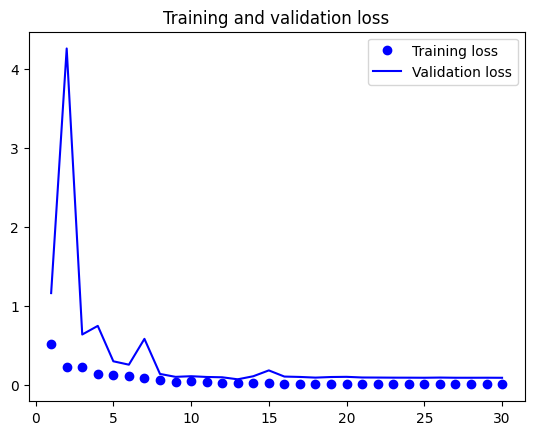

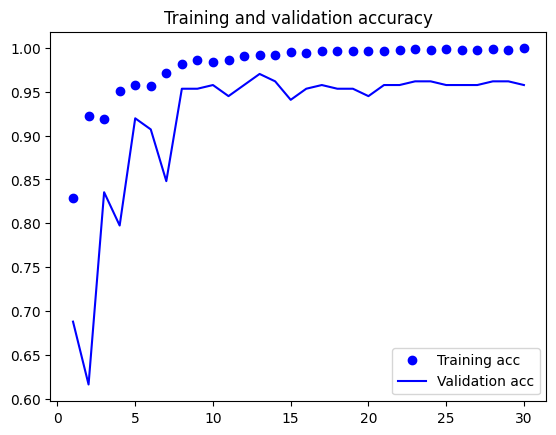

<Figure size 640x480 with 0 Axes>

In [ ]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [ ]:
# make a prediction
from tensorflow.keras.models import load_model

predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

<ipython-input-36-f01537319b51>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)


237/237 [==============================] - 1s 4ms/step


In [ ]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_gen.classes

In [ ]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(y_true, y_pred)

In [ ]:
test_gen.class_indices

{'1_healthy': 0,
 '2_fvar': 1,
 '3_var': 2,
 '4_ant': 3,
 '5_robbed': 4,
 '6_queen': 5}

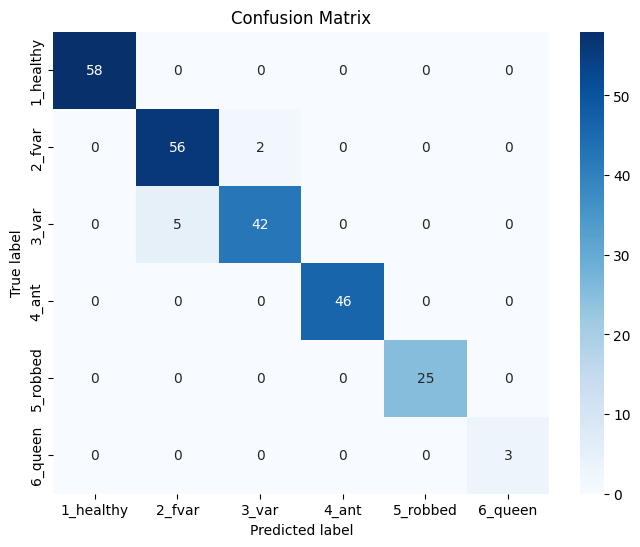

In [ ]:
# Key:
# healthy = healthy
# fvar = few varrao, hive beetles
# var = Varroa, Small Hive Beetles
# ant = ant problems
# robbed = hive being robbed
# queen = missing queen

# Define the labels of the class indices. These need to match the
# order shown above.

import seaborn as sns

cm_plot_labels = ['1_healthy', '2_fvar', '3_var', '4_ant', '5_robbed','6_queen']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_plot_labels, yticklabels=cm_plot_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
len(df_val)

237

In [ ]:
# Get the filenames, labels and associated predictions

# This outputs the sequence in which the generator processed the test images
test_filenames = test_gen.filenames

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report

names = ['healthy', 'few varrao, hive beetles', 'Varroa, Small Hive Beetles',
               'ant problems', 'hive being robbed','missing queen']

report = classification_report(y_true, y_pred, target_names=names)

print(report)

                            precision    recall  f1-score   support

                   healthy       1.00      1.00      1.00        58
  few varrao, hive beetles       0.92      0.97      0.94        58
Varroa, Small Hive Beetles       0.95      0.89      0.92        47
              ant problems       1.00      1.00      1.00        46
         hive being robbed       1.00      1.00      1.00        25
             missing queen       1.00      1.00      1.00         3

                  accuracy                           0.97       237
                 macro avg       0.98      0.98      0.98       237
              weighted avg       0.97      0.97      0.97       237

